# Binary spine segmentation

> TODOs: upload models to hugginface

In [ ]:
from fastMONAI.vision_all import *

# Train your own model 
skip to inference part...

In [ ]:
NB_DIR = Path.cwd()
DATA_DIR = NB_DIR/'..'/'data'/'spine_data'/'processed' 

In [ ]:
fold = 0
df = pd.read_csv(DATA_DIR/'processed_csv'/'magnhild_data.csv')
df.loc[df.fold == fold, 'is_val'] = True 

### Look at training data

In [ ]:
med_dataset = MedDataset(img_list=df.t2_img_path.tolist(), reorder=True, max_workers=12)

In [ ]:
data_info_df = med_dataset.summary()

In [ ]:
resample, reorder = med_dataset.suggestion()
resample, reorder

([4.4, 0.7813, 0.7812], True)

In [ ]:
resample=[4.4, 0.78, 0.78]

In [ ]:
bs=4

In [ ]:
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[17.0, 385.0, 385.0]

In [ ]:
size = [16,400,400]

In [ ]:
item_tfms = [ZNormalization(), PadOrCrop(size), 
             RandomGamma(log_gamma=(-0.2,0.2), p=0.5), RandomAffine(scales=(0.9, 1.1), degrees=5, p=0.5), 
             RandomElasticDeformation(num_control_points=5, max_displacement=5.5, p=0.5)]

In [ ]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock), 
                      splitter=ColSplitter('is_val'),
                      get_x=ColReader('t2_img_path'),
                      get_y=ColReader('t2_mask_path'),
                      item_tfms=item_tfms,
                      reorder=reorder,
                      resample=resample) 

In [ ]:
dls = dblock.dataloaders(df, bs=bs)

In [ ]:
# training and validation
len(dls.train_ds.items), len(dls.valid_ds.items)

(12, 3)

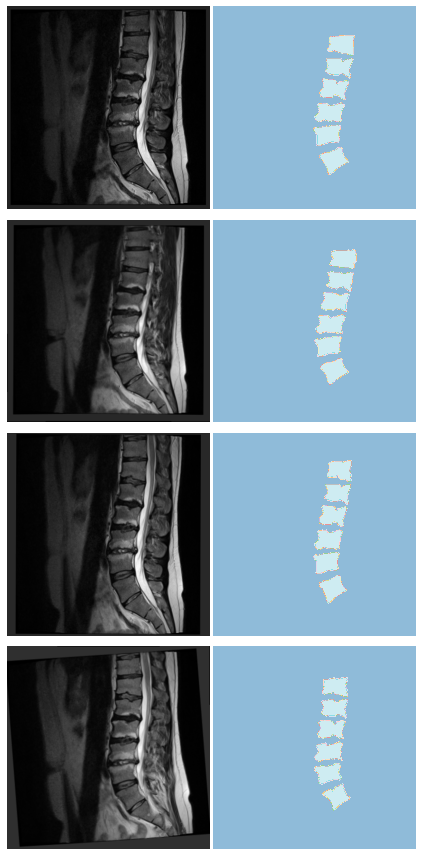

In [ ]:
dls.show_batch(unique=True, anatomical_plane=0) 

### Create and train a 3D model

The current state-of-the-art CNN models for medical image segmentation tasks are based on encoder-decoder architectures like the U-Net. 
In the following line, we import an enhanced version of 3D UNet from MONAI. In addition, we import the Dice coefficient (Dice) loss, a commonly used loss function in medical image segmentation tasks: 
\begin{equation*}
\begin{aligned}
loss = 1- \frac{y \cap \hat{y}}{\left | y \right |+\left | \hat{y} \right |}
\end{aligned}
\end{equation*}

In [ ]:
from monai.networks.nets import UNet

TODO: refactorize

In [ ]:
loss_func = CustomLoss(loss_func=TverskyFocalLoss(to_onehot_y=True, include_background=True, softmax=True))
model = UNet(spatial_dims=3, in_channels=1, out_channels=2, channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2), num_res_units=2)
model = model.model
learn = Learner(dls, model, loss_func=loss_func, opt_func=ranger, metrics=[multi_dice_score])

SuggestedLRs(valley=0.001737800776027143)

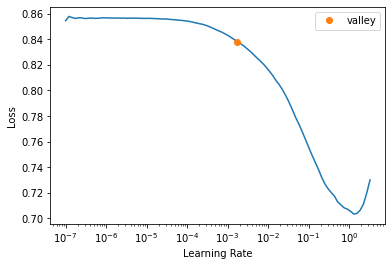

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-2

In [ ]:
learn.fit_flat_cos(5 ,lr)

epoch,train_loss,valid_loss,multi_dice_score,time
0,0.831339,0.827995,0.068211,00:07
1,0.826379,0.803024,0.073456,00:06
2,0.808984,0.748459,0.060932,00:06
3,0.788949,0.735407,0.079995,00:07
4,0.774229,0.700708,0.089895,00:07
5,0.758337,0.696548,0.089500,00:07
6,0.745894,0.665654,0.099223,00:08
7,0.732043,0.663549,0.100180,00:07
8,0.720822,0.633775,0.107396,00:07
9,0.708379,0.633550,0.107506,00:07


In [ ]:
learn.save('tmp-model')

In [ ]:
store_variables(pkl_fn='models/vars.pkl', var_vals=[reorder, resample])

### Inference on test data

In [ ]:
from huggingface_hub import snapshot_download
from scipy.ndimage import label
from skimage.morphology import remove_small_objects

In [ ]:
models_path = snapshot_download(repo_id="skaliy/spine-segmentation",  cache_dir='models', allow_patterns="*.pth")

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
models_path

'models/models--skaliy--spine-segmentation/snapshots/f95d69d1d46d30fed67094dffe831630363b474c'

In [ ]:
model_list = list(Path(models_path).glob('*.pth'))

In [ ]:
external_data = snapshot_download(repo_id="skaliy/spine-segmentation",  cache_dir='data', allow_patterns="*.zip")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
shutil.unpack_archive(Path(external_data)/'external_t2w_spine.zip', 'data')

In [ ]:
DATA_DIR = Path('data/external_t2w_spine')

In [ ]:
img_list = glob.glob(str(DATA_DIR/'img/*.nii.gz'))
mask_list = [str(fn).replace('img', 'seg') for fn in img_list]
subject_id_list = [fn.split('_')[-1].split('.')[0] for fn in img_list]

In [ ]:
data = {'t2_img_path':img_list, 't2_mask_path':mask_list, 'subject_id':subject_id_list}
df_test = pd.DataFrame(data)

In [ ]:
item_tfms = [ZNormalization(), PadOrCrop(size)]

In [ ]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock), 
                      splitter=None,
                      get_x=ColReader('t2_img_path'),
                      get_y=ColReader('t2_mask_path'),
                      item_tfms=item_tfms,
                      reorder=reorder,
                      resample=resample) 

In [ ]:
dls = dblock.dataloaders(df, bs=bs)

In [ ]:
learn = Learner(dls, model, loss_func=loss_func, opt_func=ranger)

In [ ]:
test_dl = learn.dls.test_dl(df_test,with_labels=True)

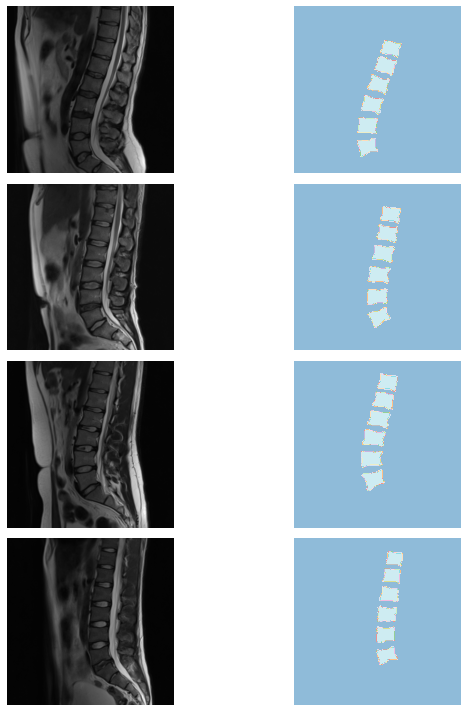

In [ ]:
test_dl.show_batch(anatomical_plane=0, figsize=(10,10))

In [ ]:
input_imgs, _, labels = learn.get_preds(dl=test_dl, with_input=True)
labels.shape

torch.Size([23, 1, 16, 400, 400])

In [ ]:
model_list = [(('/').join(fn.parts[1:])).replace('.pth', '')for fn in model_list]

In [ ]:
n_folds=3
ensemble_acts = None
for idx, fn in enumerate(model_list): 
    learn.load(str(fn).split('.')[0])
    learn.export(f'models/{idx}_learner.pkl')
    
    pred_acts, _ = learn.get_preds(dl=test_dl)
        
    
    ensemble_acts = pred_acts if ensemble_acts is None else ensemble_acts + pred_acts

In [ ]:
ensemble_acts = ensemble_acts/n_folds
ensemble_acts.shape

torch.Size([23, 2, 16, 400, 400])

In [ ]:
pred_masks,_ = batch_pred_to_multiclass_mask(ensemble_acts)

In [ ]:
raw_ensemble_dsc = calculate_dsc(pred_masks, labels)

In [ ]:
torch.mean(raw_ensemble_dsc), torch.std(raw_ensemble_dsc)

(tensor(0.8956), tensor(0.0212))

In [ ]:
raw_ensemble_haus = calculate_haus(pred_masks, labels)
torch.mean(raw_ensemble_haus),torch.std(raw_ensemble_haus)

(tensor(53.3998), tensor(39.7330))

In [ ]:
def pred_postprocess(pred_mask, avg_disc=10437, percentage=0.2): 
    small_objects = avg_disc*percentage    
    labeled_mask, ncomponents = label(pred_mask)
    labeled_mask = remove_small_objects(np.array(labeled_mask), min_size=small_objects)

    return torch.Tensor(np.where(labeled_mask>0, 1., 0.))

In [ ]:
df_test['raw_ensemble_dsc'] = raw_ensemble_dsc
df_test['raw_ensemble_haus'] = raw_ensemble_haus

In [ ]:
post_pred_masks = [pred_postprocess(pred) for pred in pred_masks]

In [ ]:
post_dsc = calculate_dsc(post_pred_masks, labels)
torch.mean(post_dsc), torch.std(post_dsc)

(tensor(0.8990), tensor(0.0199))

In [ ]:
post_haus = calculate_haus(post_pred_masks, labels)
torch.mean(post_haus), torch.std(post_haus)

(tensor(12.0519), tensor(11.6195))

In [ ]:
df_test['postprocessed_ensemble_dsc'] = post_dsc
df_test['postprocessed_ensemble_haus'] = post_haus

In [ ]:
df_test = df_test.sort_values('subject_id').reset_index(drop=True)

In [ ]:
df_test

,t2_img_path,t2_mask_path,subject_id,raw_ensemble_dsc,raw_ensemble_haus,postprocessed_ensemble_dsc,postprocessed_ensemble_haus
0,data/external_t2w_spine/img/Img_01.nii.gz,data/external_t2w_spine/seg/Img_01.nii.gz,01,0.918600,19.052559,0.921241,6.708204
1,data/external_t2w_spine/img/Img_02.nii.gz,data/external_t2w_spine/seg/Img_02.nii.gz,02,0.917546,4.242640,0.917546,4.242640
2,data/external_t2w_spine/img/Img_03.nii.gz,data/external_t2w_spine/seg/Img_03.nii.gz,03,0.868997,66.392769,0.880941,35.468296
3,data/external_t2w_spine/img/Img_04.nii.gz,data/external_t2w_spine/seg/Img_04.nii.gz,04,0.877634,18.601076,0.877997,18.601076
4,data/external_t2w_spine/img/Img_05.nii.gz,data/external_t2w_spine/seg/Img_05.nii.gz,05,0.926372,86.261230,0.927981,7.071068
5,data/external_t2w_spine/img/Img_06.nii.gz,data/external_t2w_spine/seg/Img_06.nii.gz,06,0.913778,8.062258,0.913778,8.062258
6,data/external_t2w_spine/img/Img_07.nii.gz,data/external_t2w_spine/seg/Img_07.nii.gz,07,0.883685,110.607414,0.902101,5.000000
7,data/external_t2w_spine/img/Img_08.nii.gz,data/external_t2w_spine/seg/Img_08.nii.gz,08,0.922395,5.477226,0.922395,5.477226
8,data/external_t2w_spine/img/Img_09.nii.gz,data/external_t2w_spine/seg/Img_09.nii.gz,09,0.900216,87.344147,0.901496,8.660254
9,data/external_t2w_spine/img/Img_10.nii.gz,data/external_t2w_spine/seg/Img_10.nii.gz,10,0.909385,64.101479,0.909481,4.582576
